#### Week 3 Presentation Notebooks in a better form

This notebook compares iBLR,CVI and Sampling Method in with a nonlinearity in the factor graph with different hyperparameters and optimizer choice.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

 Activating environment at `C:\AlpOkul\TUe_Masters\Internship_BIASLab\CVI_AlpSemih\Project.toml`


In [2]:
using Random,LinearAlgebra, Flux.Optimise, Plots, ForneyLab
using ForneyLab:iBLR
using JLD2 # Used to save data
using TimerOutputs

## Data with symmetric nonlinearity

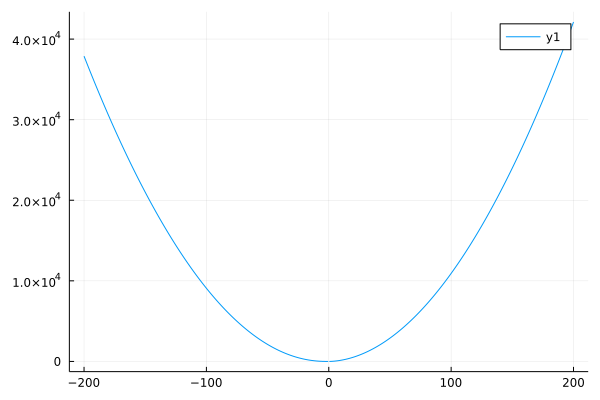

In [3]:
# Data and the Underlying Function
true_value = 120.0
Random.seed!(1234)
N=10
σ(x) = 1/(1+exp(-x))
f(x)= x^2+σ(x)tanh(x)+2*log(abs(x))*x
y_obs = Vector{Float64}(undef,N)
for i=1:N
    y_obs[i] = f(true_value)+1*randn()
end

x_range = -200:0.5:200
y_plot = f.(x_range)
plot(x_range,y_plot)

In [4]:
mutable struct Week3Data
    method::String
    stepsize::Float64
    num_samples::Float64
    num_iterations::Float64
    elapsed_time::Float64
    data::Vector
    true_value::Float64
end

## iBLR Examples

In [5]:
import ForneyLab: step!
stepsize_array = [10^(-i) for i in 0:10.]
num_iterations_array = [10^(i) for i in 1:7.]
num_samples = 1000
method = "iBLR"
save_name_counter = 1
data_all_iblr=Dict()
for stepsize in stepsize_array,num_iterations in num_iterations_array
    println("Currently at: stepsize =$stepsize, #iterations = $num_iterations")
    g = FactorGraph()
    @RV x ~ GaussianMeanVariance(1.0, 100.0)
    @RV m ~ Cvi(x,g=f,opt=iBLR(stepsize),num_samples=num_samples,num_iterations=Int64(num_iterations))
    @RV y ~ GaussianMeanVariance(m, 100.0)
    placeholder(y, :y)
    # Infer algorithm
    pfz = PosteriorFactorization(g)
    algo = messagePassingAlgorithm(x)
    source_code = algorithmSourceCode(algo)
    eval(Meta.parse(source_code));
    # Apply Algorithm
    to =TimerOutput()
    marginals = Dict()
    mean_over_iterations = Vector{Float64}(undef,N)
    @timeit to "Total_Iterations" begin 
    for i=1:N
        data = Dict(:y => y_obs[1])
        marginals = step!(data,marginals)
        #println("i=$i,iBLR result = $(mean(marginals[:x]))")
        mean_over_iterations[i] = mean(marginals[:x])
    end
    end #End macro
    println("Mean found at last iteration= $(mean_over_iterations[end])")
    # Save Stats
    savename = "$(method)_$(save_name_counter)"
    elapsed_time = TimerOutputs.time(to["Total_Iterations"])/1000000 #ms
    stats = Week3Data(method,stepsize,num_samples,num_iterations,elapsed_time,mean_over_iterations,true_value)
    data_all_iblr[savename]=stats #Append to data_all
    save_object("W3_$(method)_results/$(savename).jld2", stats) #Save Week3Data Type
    println("Data saved for iteration $(save_name_counter)")
    save_name_counter +=1
    println("-----")
end #End stepsize, num iterations loop
save_object("W3_$(method)_results/data_all.jld2",data_all_iblr)#Save Dictionary 

Currently at: stepsize =1.0, #iterations = 10.0
Mean found at last iteration= -8.401418030568378e6
Data saved for iteration 1
-----
Currently at: stepsize =1.0, #iterations = 100.0
Mean found at last iteration= -1.3856913592797485e6
Data saved for iteration 2
-----
Currently at: stepsize =1.0, #iterations = 1000.0
Mean found at last iteration= -1.187352312833173e9
Data saved for iteration 3
-----
Currently at: stepsize =1.0, #iterations = 10000.0
Mean found at last iteration= -5.309637049158908e6
Data saved for iteration 4
-----
Currently at: stepsize =1.0, #iterations = 100000.0
Mean found at last iteration= -1.482678559605411e6
Data saved for iteration 5
-----
Currently at: stepsize =1.0, #iterations = 1.0e6
Mean found at last iteration= -1.937923343276782e7
Data saved for iteration 6
-----
Currently at: stepsize =1.0, #iterations = 1.0e7
Mean found at last iteration= -2.713542611908586e8
Data saved for iteration 7
-----
Currently at: stepsize =0.1, #iterations = 10.0
Mean found at l

Mean found at last iteration= 119.81333849995247
Data saved for iteration 61
-----
Currently at: stepsize =1.0e-8, #iterations = 1.0e6
Mean found at last iteration= 119.95256578713071
Data saved for iteration 62
-----
Currently at: stepsize =1.0e-8, #iterations = 1.0e7
Mean found at last iteration= 119.99918587034321
Data saved for iteration 63
-----
Currently at: stepsize =1.0e-9, #iterations = 10.0
Mean found at last iteration= 1.0026311257092957
Data saved for iteration 64
-----
Currently at: stepsize =1.0e-9, #iterations = 100.0
Mean found at last iteration= 1.0167501109107437
Data saved for iteration 65
-----
Currently at: stepsize =1.0e-9, #iterations = 1000.0
Mean found at last iteration= 1.1056387480247287
Data saved for iteration 66
-----
Currently at: stepsize =1.0e-9, #iterations = 10000.0
Mean found at last iteration= 2.606870061163387
Data saved for iteration 67
-----
Currently at: stepsize =1.0e-9, #iterations = 100000.0
Mean found at last iteration= 13.56037404446875
Dat

## Descent Examples

In [6]:
import ForneyLab: step!
stepsize_array = [10^(-i) for i in 0:10.]
num_iterations_array = [10^(i) for i in 1:7.]
num_samples = 1000
method = "Descent"
save_name_counter = 1
data_all_iblr=Dict()
for stepsize in stepsize_array,num_iterations in num_iterations_array
    println("Currently at: stepsize =$stepsize, #iterations = $num_iterations")
    g = FactorGraph()
    @RV x ~ GaussianMeanVariance(1.0, 100.0)
    @RV m ~ Cvi(x,g=f,opt=Descent(stepsize),num_samples=num_samples,num_iterations=Int64(num_iterations))
    @RV y ~ GaussianMeanVariance(m, 100.0)
    placeholder(y, :y)
    # Infer algorithm
    pfz = PosteriorFactorization(g)
    algo = messagePassingAlgorithm(x)
    source_code = algorithmSourceCode(algo)
    eval(Meta.parse(source_code));
    # Apply Algorithm
    to =TimerOutput()
    marginals = Dict()
    mean_over_iterations = Vector{Float64}(undef,N)
    @timeit to "Total_Iterations" begin 
    for i=1:N
        data = Dict(:y => y_obs[1])
        marginals = step!(data,marginals)
        #println("i=$i,iBLR result = $(mean(marginals[:x]))")
        mean_over_iterations[i] = mean(marginals[:x])
    end
    end #End macro
    println("Mean found at last iteration= $(mean_over_iterations[end])")
    # Save Stats
    savename = "$(method)_$(save_name_counter)"
    elapsed_time = TimerOutputs.time(to["Total_Iterations"])/1000000 #ms
    stats = Week3Data(method,stepsize,num_samples,num_iterations,elapsed_time,mean_over_iterations,true_value)
    data_all_iblr[savename]=stats #Append to data_all
    save_object("W3_$(method)_results/$(savename).jld2", stats) #Save Week3Data Type
    println("Data saved for iteration $(save_name_counter)")
    save_name_counter +=1
    println("-----")
end #End stepsize, num iterations loop
save_object("W3_$(method)_results/data_all.jld2",data_all_iblr)#Save Dictionary 

Currently at: stepsize =1.0, #iterations = 10.0
Mean found at last iteration= 0.8350263896861378
Data saved for iteration 1
-----
Currently at: stepsize =1.0, #iterations = 100.0
Mean found at last iteration= 0.8676966807460157
Data saved for iteration 2
-----
Currently at: stepsize =1.0, #iterations = 1000.0
Mean found at last iteration= 0.853428990149426
Data saved for iteration 3
-----
Currently at: stepsize =1.0, #iterations = 10000.0
Mean found at last iteration= 0.8913010012191688
Data saved for iteration 4
-----
Currently at: stepsize =1.0, #iterations = 100000.0
Mean found at last iteration= 0.8998160327215288
Data saved for iteration 5
-----
Currently at: stepsize =1.0, #iterations = 1.0e6
Mean found at last iteration= 0.8875636014768261
Data saved for iteration 6
-----
Currently at: stepsize =1.0, #iterations = 1.0e7
Mean found at last iteration= 0.9004233496911646
Data saved for iteration 7
-----
Currently at: stepsize =0.1, #iterations = 10.0
Mean found at last iteration= 1

Mean found at last iteration= 119.98233911554797
Data saved for iteration 62
-----
Currently at: stepsize =1.0e-8, #iterations = 1.0e7
Mean found at last iteration= 119.99910734438984
Data saved for iteration 63
-----
Currently at: stepsize =1.0e-9, #iterations = 10.0
Mean found at last iteration= 1.0000289223102594
Data saved for iteration 64
-----
Currently at: stepsize =1.0e-9, #iterations = 100.0
Mean found at last iteration= 1.0064479151686012
Data saved for iteration 65
-----
Currently at: stepsize =1.0e-9, #iterations = 1000.0
Mean found at last iteration= 1.124060132348692
Data saved for iteration 66
-----
Currently at: stepsize =1.0e-9, #iterations = 10000.0
Mean found at last iteration= 2.641434848833213
Data saved for iteration 67
-----
Currently at: stepsize =1.0e-9, #iterations = 100000.0
Mean found at last iteration= 118.23788480978723
Data saved for iteration 68
-----
Currently at: stepsize =1.0e-9, #iterations = 1.0e6
Mean found at last iteration= 119.81561652882208
Dat

## ADAM Examples

In [5]:
import ForneyLab: step!
stepsize_array = [10^(-i) for i in 0:10.]
num_iterations_array = [10^(i) for i in 1:5.]
num_samples = 1000
method = "ADAM"
save_name_counter = 1
data_all_iblr=Dict()
for stepsize in stepsize_array,num_iterations in num_iterations_array
    println("Currently at: stepsize =$stepsize, #iterations = $num_iterations")
    g = FactorGraph()
    @RV x ~ GaussianMeanVariance(1.0, 100.0)
    @RV m ~ Cvi(x,g=f,opt=ADAM(stepsize),num_samples=num_samples,num_iterations=Int64(num_iterations))
    @RV y ~ GaussianMeanVariance(m, 100.0)
    placeholder(y, :y)
    # Infer algorithm
    pfz = PosteriorFactorization(g)
    algo = messagePassingAlgorithm(x)
    source_code = algorithmSourceCode(algo)
    eval(Meta.parse(source_code));
    # Apply Algorithm
    to =TimerOutput()
    marginals = Dict()
    mean_over_iterations = Vector{Float64}(undef,N)
    @timeit to "Total_Iterations" begin 
    for i=1:N
        data = Dict(:y => y_obs[1])
        marginals = step!(data,marginals)
        #println("i=$i,iBLR result = $(mean(marginals[:x]))")
        mean_over_iterations[i] = mean(marginals[:x])
    end
    end #End macro
    println("Mean found at last iteration= $(mean_over_iterations[end])")
    # Save Stats
    savename = "$(method)_$(save_name_counter)"
    elapsed_time = TimerOutputs.time(to["Total_Iterations"])/1000000 #ms
    stats = Week3Data(method,stepsize,num_samples,num_iterations,elapsed_time,mean_over_iterations,true_value)
    data_all_iblr[savename]=stats #Append to data_all
    save_object("W3_$(method)_results/$(savename).jld2", stats) #Save Week3Data Type
    println("Data saved for iteration $(save_name_counter)")
    save_name_counter +=1
    println("-----")
end #End stepsize, num iterations loop
save_object("W3_$(method)_results/data_all.jld2",data_all_iblr)#Save Dictionary 

Currently at: stepsize =1.0, #iterations = 10.0
Mean found at last iteration= 1.0
Data saved for iteration 1
-----
Currently at: stepsize =1.0, #iterations = 100.0
Mean found at last iteration= 4.3178499537430834
Data saved for iteration 2
-----
Currently at: stepsize =1.0, #iterations = 1000.0
Mean found at last iteration= 9.182701923803817
Data saved for iteration 3
-----
Currently at: stepsize =1.0, #iterations = 10000.0
Mean found at last iteration= 14.245879330692718
Data saved for iteration 4
-----
Currently at: stepsize =1.0, #iterations = 100000.0
Mean found at last iteration= 8.348942275275252
Data saved for iteration 5
-----
Currently at: stepsize =0.1, #iterations = 10.0
Mean found at last iteration= 1.0
Data saved for iteration 6
-----
Currently at: stepsize =0.1, #iterations = 100.0
Mean found at last iteration= -1.3710962036653984
Data saved for iteration 7
-----
Currently at: stepsize =0.1, #iterations = 1000.0
Mean found at last iteration= 43.9836597693501
Data saved fo

## Example Code Below for one iteration

In [27]:
# ### iBLR(1e-7) num_iterations = 1000

# num_samples = 1000
# num_iterations =100
# stepsize = 1e-7
# #
# g = FactorGraph()
# @RV x ~ GaussianMeanVariance(1.0, 100.0)
# @RV m ~ Cvi(x,g=f,opt=iBLR(stepsize),num_samples=num_samples,num_iterations=num_iterations)
# @RV y ~ GaussianMeanVariance(m, 100.0)
# placeholder(y, :y)
# # Infer algorithm
# pfz = PosteriorFactorization(g)
# algo = messagePassingAlgorithm(x)
# source_code = algorithmSourceCode(algo)
# eval(Meta.parse(source_code));
# to =TimerOutput()
# marginals = Dict()
# mean_over_iterations = Vector{Float64}(undef,N)
# @timeit to "Total_Iterations" begin 
# for i=1:N
#     data = Dict(:y => y_obs[1])
#     marginals = step!(data,marginals)
#     println("i=$i,iBLR result = $(mean(marginals[:x]))")
#     mean_over_iterations[i] = mean(marginals[:x])
# end
# end #End macro

# # Save Stats
# savename = "iBLR_1"
# method = "iBLR"
# elapsed_time = TimerOutputs.time(to["Total_Iterations"])/1000000 #ms
# stats = Week3Data(method,stepsize,num_samples,num_iterations,elapsed_time,mean_over_iterations,true_value)
# data_all[savename]=stats #Append to data_all
# save_object("$savename.jld2", stats) #Save Week3Data Type

In [ ]:
import ForneyLab: step!
stepsize_array = [10^(-i) for i in 0:10.]
num_iterations_array = [10^(7)]
num_samples = 1000
method = "ADAM"
save_name_counter = 67
data_all_iblr=Dict()
for stepsize in stepsize_array,num_iterations in num_iterations_array
    println("Currently at: stepsize =$stepsize, #iterations = $num_iterations")
    g = FactorGraph()
    @RV x ~ GaussianMeanVariance(1.0, 100.0)
    @RV m ~ Cvi(x,g=f,opt=ADAM(stepsize),num_samples=num_samples,num_iterations=Int64(num_iterations))
    @RV y ~ GaussianMeanVariance(m, 100.0)
    placeholder(y, :y)
    # Infer algorithm
    pfz = PosteriorFactorization(g)
    algo = messagePassingAlgorithm(x)
    source_code = algorithmSourceCode(algo)
    eval(Meta.parse(source_code));
    # Apply Algorithm
    to =TimerOutput()
    marginals = Dict()
    mean_over_iterations = Vector{Float64}(undef,N)
    @timeit to "Total_Iterations" begin 
    for i=1:N
        data = Dict(:y => y_obs[1])
        marginals = step!(data,marginals)
        println("i=$i,iBLR result = $(mean(marginals[:x]))")
        mean_over_iterations[i] = mean(marginals[:x])
    end
    end #End macro
    println("Mean found at last iteration= $(mean_over_iterations[end])")
    # Save Stats
    savename = "$(method)_$(save_name_counter)"
    elapsed_time = TimerOutputs.time(to["Total_Iterations"])/1000000 #ms
    stats = Week3Data(method,stepsize,num_samples,num_iterations,elapsed_time,mean_over_iterations,true_value)
    data_all_iblr[savename]=stats #Append to data_all
    save_object("W3_$(method)_results/$(savename).jld2", stats) #Save Week3Data Type
    println("Data saved for iteration $(save_name_counter)")
    save_name_counter +=1
    println("-----")
end #End stepsize, num iterations loop
#save_object("W3_$(method)_results/data_all.jld2",data_all_iblr)#Save Dictionary 

Currently at: stepsize =1.0, #iterations = 10000000
i=1,iBLR result = 16.004274948310496
i=2,iBLR result = 24.747152424413354
i=3,iBLR result = 120.05968053929534


In [13]:
data_all_iblr["ADAM_1"].data

10-element Array{Float64,1}:
 35.83854381090026
 24.874064283279605
 11.997450983807475
 26.809635973486063
 14.591473806483874
 14.166886835567356
  8.95893699009787
 16.68436162702101
 14.32952261932137
  9.210459053490233